In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np




In [134]:

# from google.colab import drive

# drive.mount('/content/drive')


# # Load the dataset
# df = pd.read_csv('/content/drive/MyDrive/train.csv')

# Load the dataset
file_path = "train.csv"  # Ensure the file is in your working directory
df = pd.read_csv(file_path)

# Display basic info
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# <span style="color:white">Data preprocessing :Visualizing, handling missing data</span>


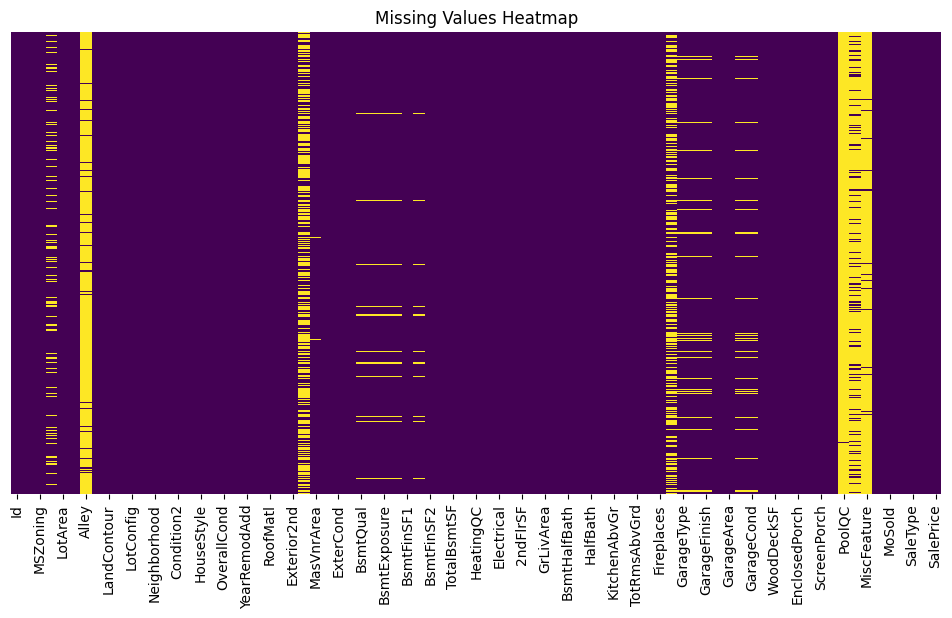

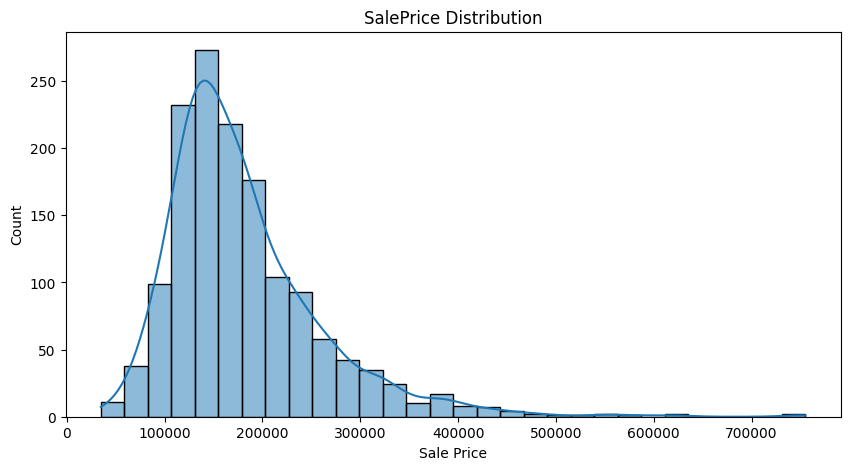

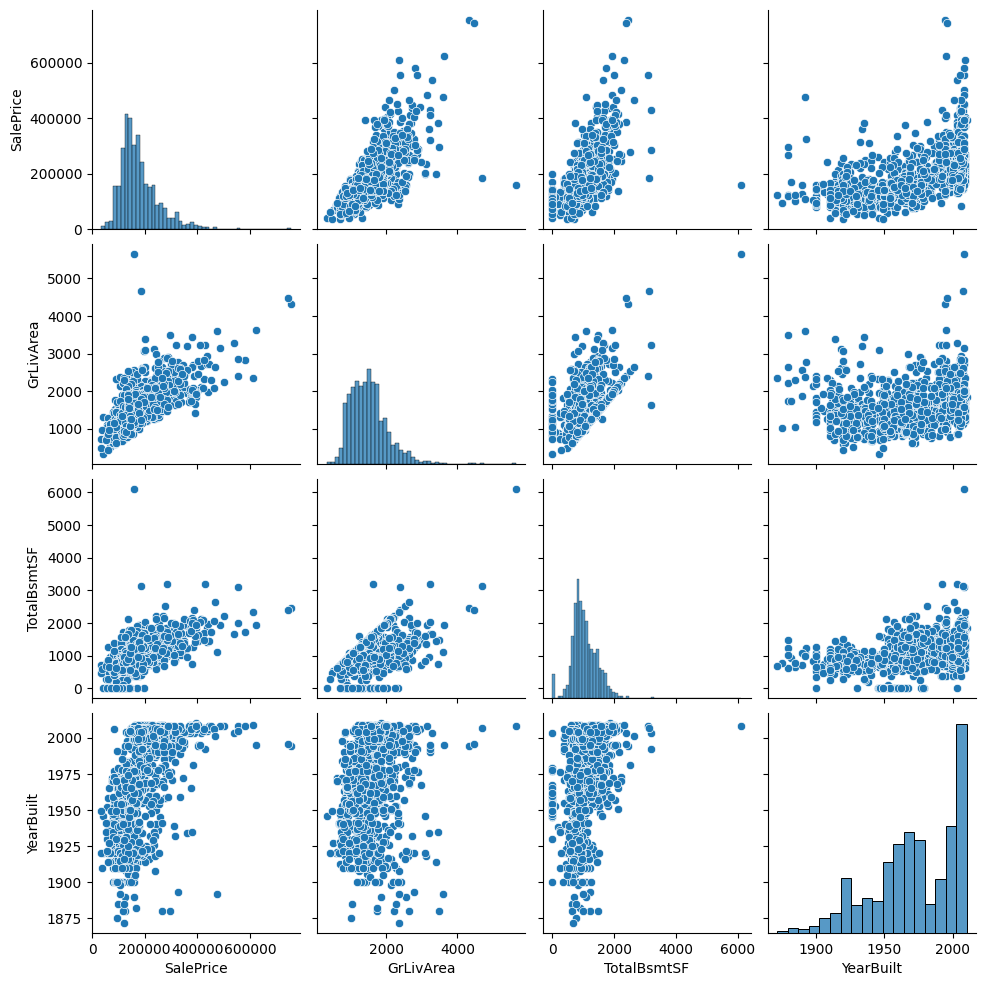

In [135]:

# Visualizing missing values
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

# Distribution of target variable (SalePrice)
plt.figure(figsize=(10, 5))
sns.histplot(df['SalePrice'], bins=30, kde=True)
plt.title("SalePrice Distribution")
plt.xlabel("Sale Price")
plt.ylabel("Count")
plt.show()

# Pairplot of selected numerical features (including SalePrice)
selected_features = ["SalePrice", "GrLivArea", "TotalBsmtSF", "YearBuilt"]
sns.pairplot(df[selected_features])
plt.show()


Missing Values (%):
PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64


C:\Users\shex\AppData\Local\Temp\ipykernel_12004\2255362329.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_data.index, y=missing_data.values, palette="viridis")


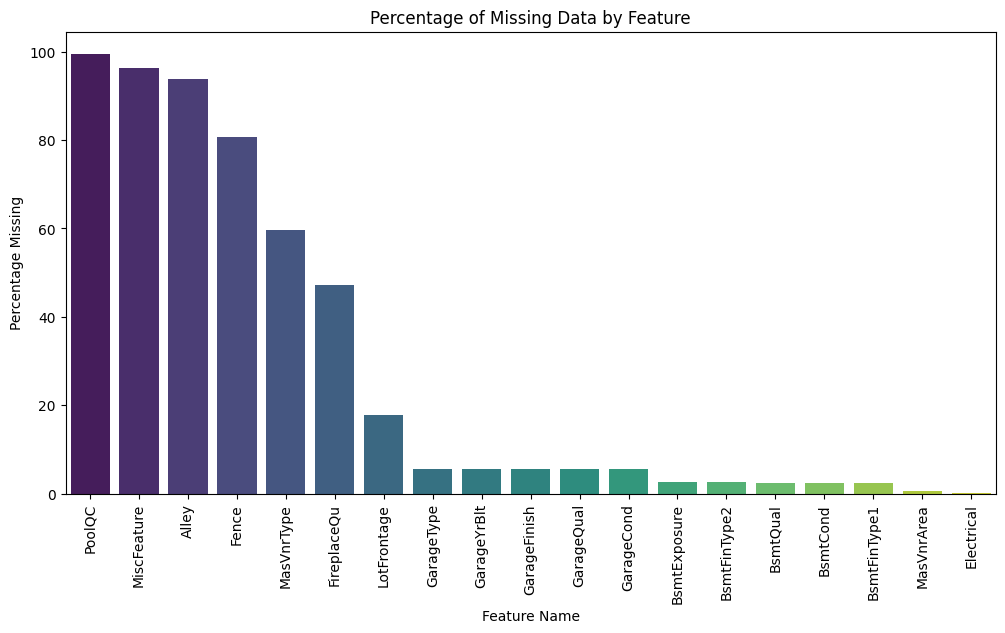

In [136]:
# Check missing values percentage
missing_data = df.isnull().sum() / len(df) * 100

# Filter only columns with missing values
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

# Display missing values
print("Missing Values (%):")
print(missing_data)

# Bar Chart of Missing Values
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_data.index, y=missing_data.values, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Feature Name")
plt.ylabel("Percentage Missing")
plt.title("Percentage of Missing Data by Feature")
plt.show()


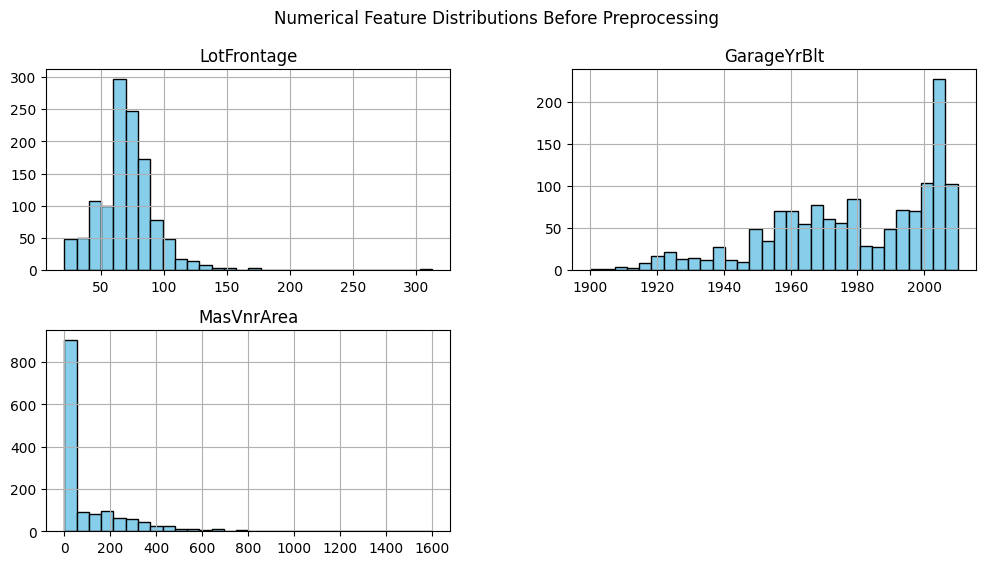

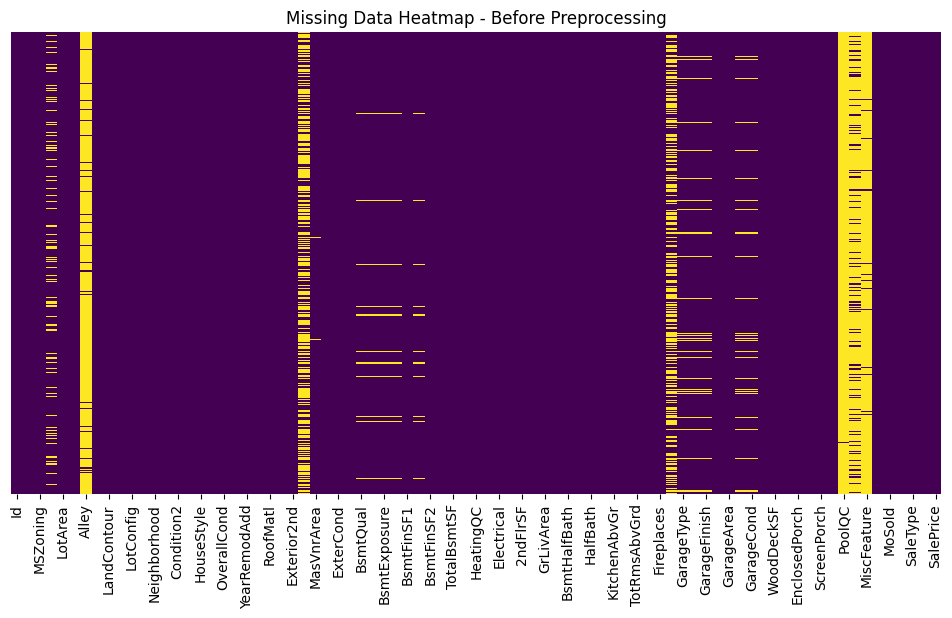

Total missing values after imputation: 0


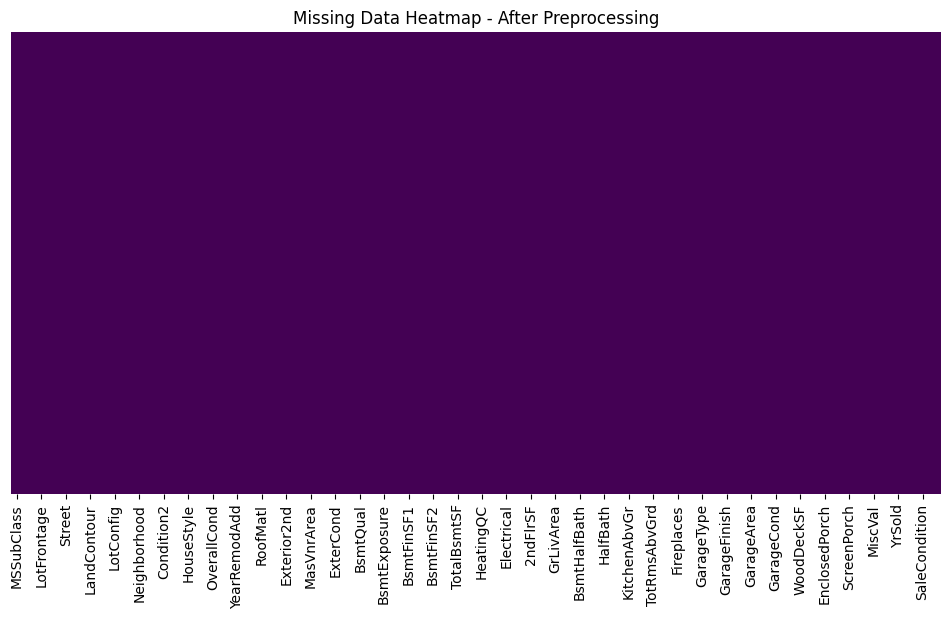

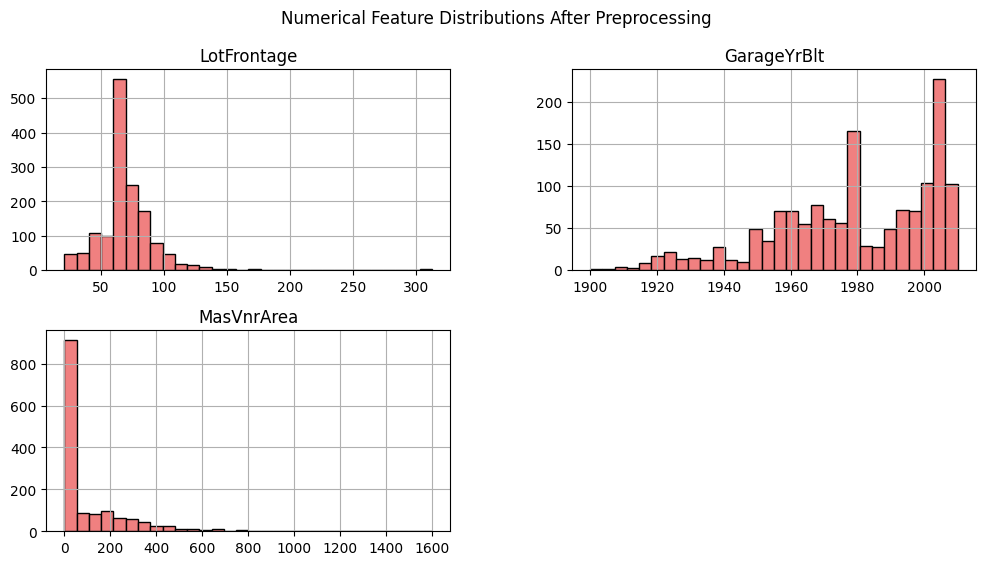

<Figure size 1200x600 with 0 Axes>

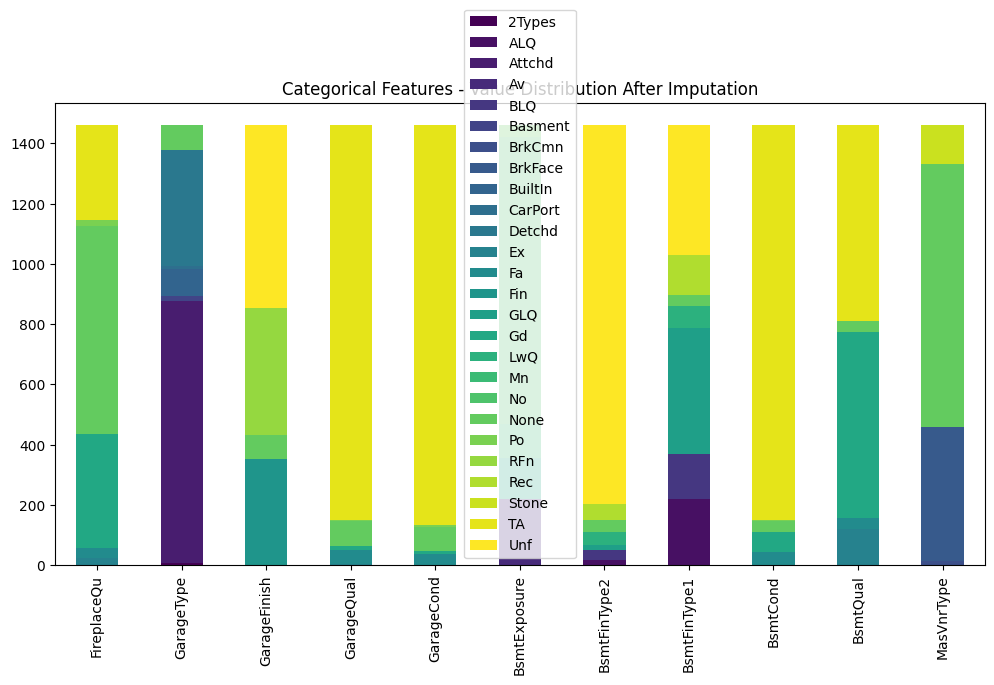

In [137]:
numerical_cols = ["LotFrontage", "GarageYrBlt", "MasVnrArea"]
# 🔹 Histogram of numerical features before preprocessing
df[numerical_cols].hist(figsize=(12, 6), bins=30, color='skyblue', edgecolor='black')
plt.suptitle("Numerical Feature Distributions Before Preprocessing")
plt.show()

# 🔹 Visualizing missing data before preprocessing
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title("Missing Data Heatmap - Before Preprocessing")
plt.show()
#

# Drop columns with too many missing values (>80%)
columns_to_drop = ["PoolQC", "MiscFeature", "Alley", "Fence"]
df.drop(columns=columns_to_drop, inplace=True)

df.drop(columns=["Id"], inplace=True)

# Fill categorical missing values with "None"
categorical_cols = ["FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond",
                    "BsmtExposure", "BsmtFinType2", "BsmtFinType1", "BsmtCond", "BsmtQual", "MasVnrType"]
df[categorical_cols] = df[categorical_cols].fillna("None")

# Fill numerical missing values with median
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

# Fill Electrical with most frequent value
df["Electrical"] = df["Electrical"].fillna(df["Electrical"].mode()[0])

# Verify no missing values remain
print(f"Total missing values after imputation: {df.isnull().sum().sum()}")



# 🔹 Visualizing missing data after preprocessing
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title("Missing Data Heatmap - After Preprocessing")
plt.show()


# 🔹 Histogram of numerical features after preprocessing
df[numerical_cols].hist(figsize=(12, 6), bins=30, color='lightcoral', edgecolor='black')
plt.suptitle("Numerical Feature Distributions After Preprocessing")
plt.show()


# Bar Chart for Categorical Features After Imputation
plt.figure(figsize=(12, 6))
df[categorical_cols].apply(lambda x: x.value_counts()).T.plot(kind="bar", stacked=True, figsize=(12,6), colormap="viridis")
plt.title("Categorical Features - Value Distribution After Imputation")
plt.xticks(rotation=90)
plt.show()

# <span style="color:white">Features Engineering :encoding</span>


In [138]:

# Identify categorical features
categorical_features = df.select_dtypes(include=["object"]).columns.tolist()

# 🔹 Ordinal Encoding for Ordered Features
ordinal_features = ["BsmtQual", "BsmtCond", "GarageQual", "GarageCond", "FireplaceQu",
                    "ExterQual", "ExterCond", "HeatingQC"]

ordinal_mapping = {
    "Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0
}

for col in ordinal_features:
    df[col] = df[col].map(ordinal_mapping)

# 🔹 Ordinal Encoding for BsmtExposure
bsmt_exposure_mapping = {"Gd": 4, "Av": 3, "Mn": 2, "No": 1, "None": 0}
df["BsmtExposure"] = df["BsmtExposure"].map(bsmt_exposure_mapping)

# 🔹 Ordinal Encoding for GarageFinish
garage_finish_mapping = {"Fin": 3, "RFn": 2, "Unf": 1, "None": 0}
df["GarageFinish"] = df["GarageFinish"].map(garage_finish_mapping)

# 🔹 One-Hot Encoding for Nominal Categorical Features
nominal_features = [col for col in categorical_features if col not in ordinal_features and col not in ["BsmtExposure", "GarageFinish"]]

df = pd.get_dummies(df, columns=nominal_features, drop_first=True)  # Drop first to avoid multicollinearity

print("Encoding complete. Data shape:", df.shape)

# 🔹 Standardize Ordinal Encoded Features for Regression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[ordinal_features + ["BsmtExposure", "GarageFinish"]] = scaler.fit_transform(df[ordinal_features + ["BsmtExposure", "GarageFinish"]])

print("Standardization complete.")



Encoding complete. Data shape: (1460, 216)
Standardization complete.


# <span style="color:white">Features Engineering : scaling</span>


<Figure size 1500x1000 with 0 Axes>

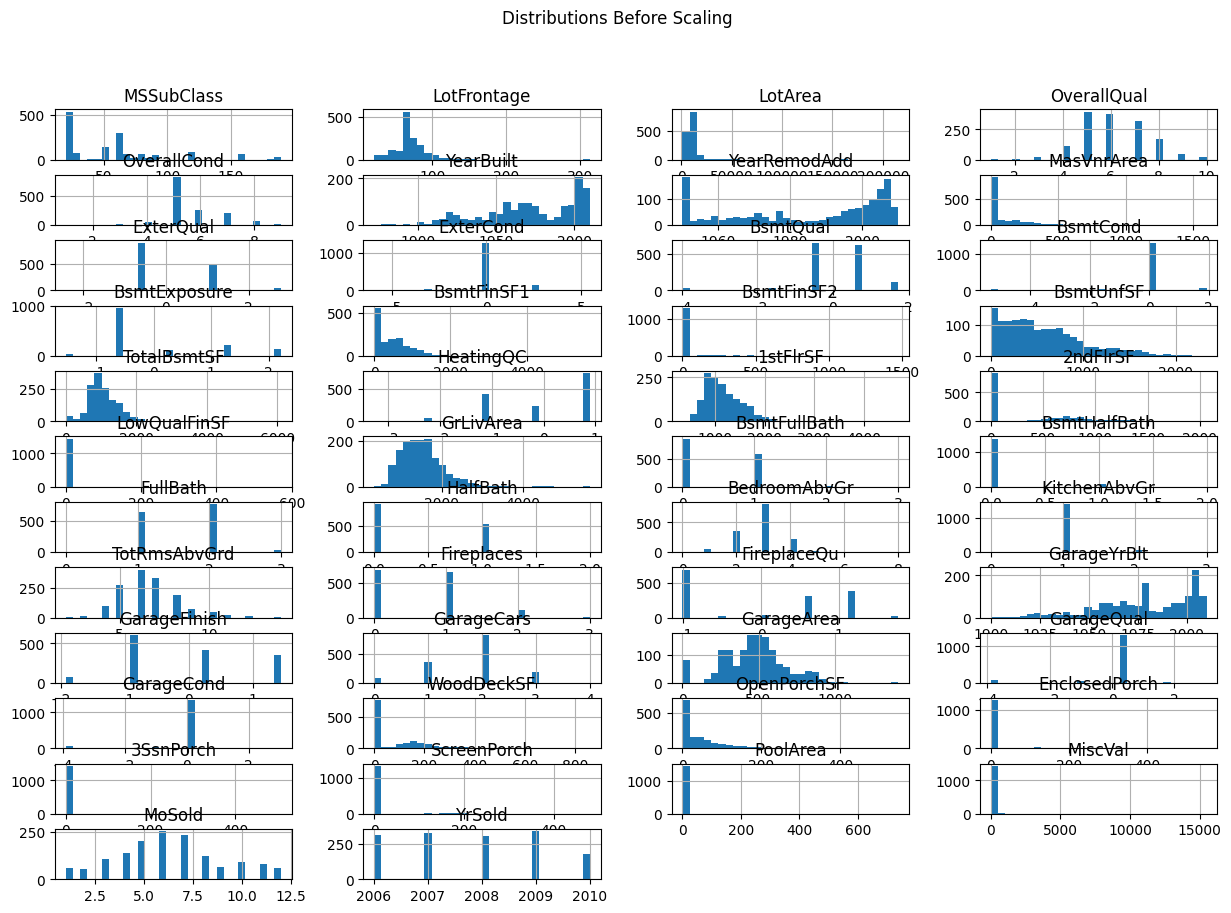

<Figure size 1500x1000 with 0 Axes>

In [ ]:

# 🔹 Identify numerical features (excluding target variable if regression)
numerical_features = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

# 🔹 Exclude target variable if it exists
target_variable = "SalePrice"
if target_variable in numerical_features:
    numerical_features.remove(target_variable)

# 🔹 Function to create histograms in multiple figures
def plot_histograms(df, features, title):
    num_features = len(features)
    cols = 4  # Number of columns in the grid
    rows = (num_features // cols) + 1  # Calculate the required rows

    for i in range(0, num_features, cols * rows):
        plt.figure(figsize=(15, 10))
        sub_features = features[i : i + (cols * rows)]  # Batch the features
        df[sub_features].hist(bins=30, figsize=(15, 10), layout=(rows, cols))
        plt.suptitle(title)
        plt.show()

# 🔹 Visualizing distributions before scaling
plot_histograms(df, numerical_features, "Distributions Before Scaling")

# 🔹 Apply Standard Scaling (Z-score Normalization)
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# 🔹 Visualizing distributions after scaling
plot_histograms(df, numerical_features, "Distributions After Scaling")



# <span style="color:white">Features Engineering :selection</span>


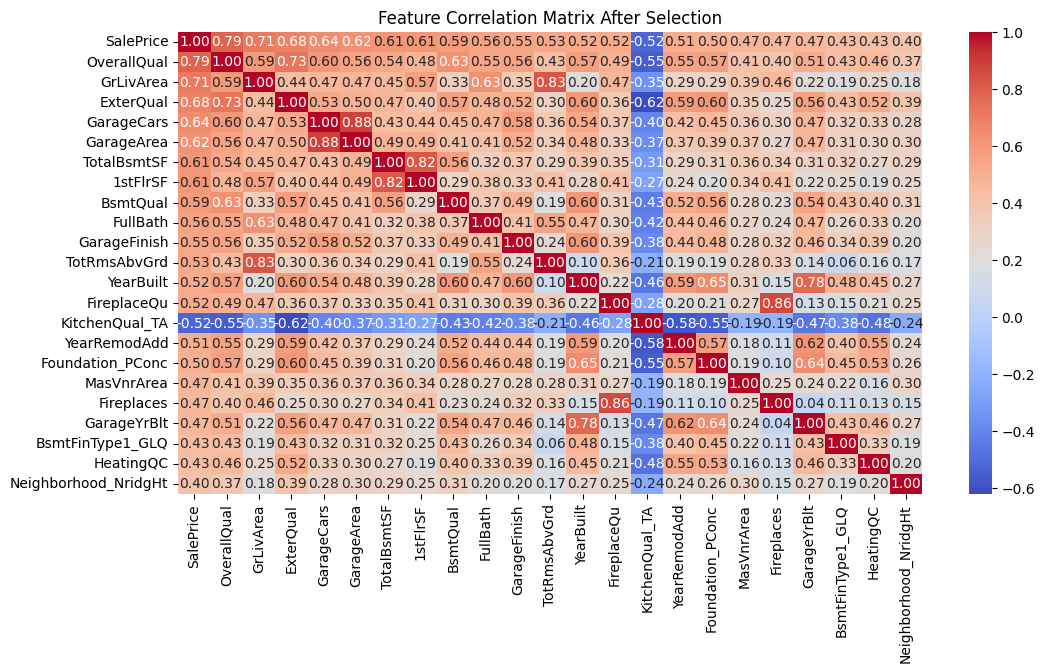

Feature selection complete. Remaining features: Index(['SalePrice', 'OverallQual', 'GrLivArea', 'ExterQual', 'GarageCars',
       'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'BsmtQual', 'FullBath',
       'GarageFinish', 'TotRmsAbvGrd', 'YearBuilt', 'FireplaceQu',
       'KitchenQual_TA', 'YearRemodAdd', 'Foundation_PConc', 'MasVnrArea',
       'Fireplaces', 'GarageYrBlt', 'BsmtFinType1_GLQ', 'HeatingQC',
       'Neighborhood_NridgHt'],
      dtype='object')


C:\Users\shex\AppData\Local\Temp\ipykernel_12004\3062169995.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation[low_vif_features].index, y=correlation[low_vif_features].values, palette="coolwarm")


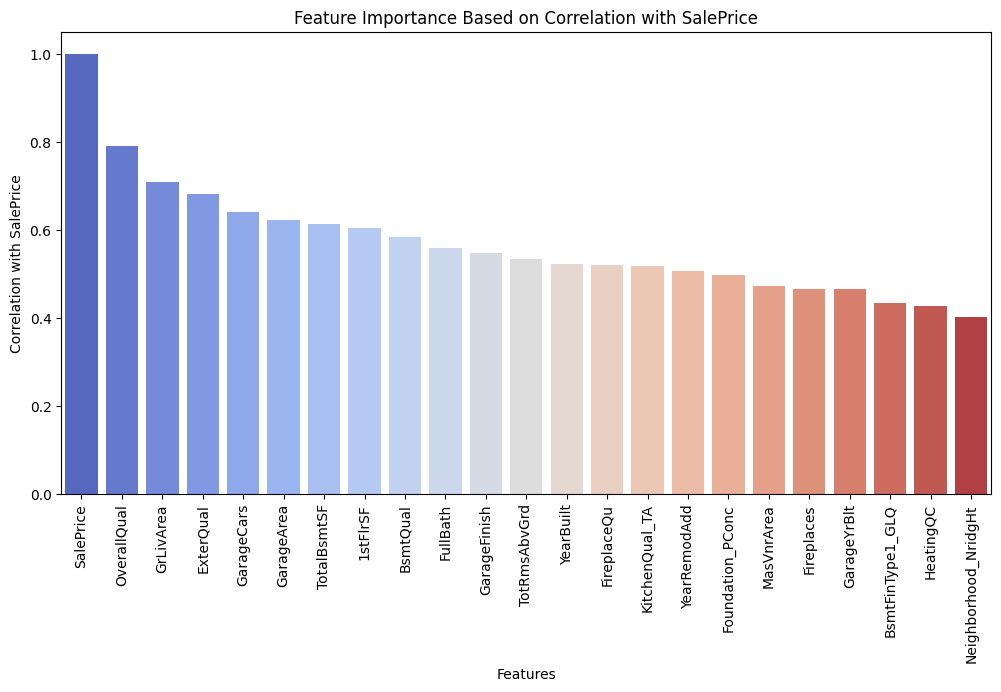

In [ ]:


# 🔹 Compute correlation with target variable
correlation = df.corr()["SalePrice"].abs().sort_values(ascending=False)

# 🔹 Select features with correlation above 0.4 (adjust as needed)
selected_features = correlation[correlation > 0.4].index.tolist()

# 🔹 Ensure all selected features are numeric
df[selected_features] = df[selected_features].apply(pd.to_numeric, errors="coerce")

# 🔹 Handle NaN and infinite values
df[selected_features] = df[selected_features].replace([np.inf, -np.inf], np.nan)
df = df.dropna()  # Drop rows with missing values

# 🔹 Function to calculate VIF
def calculate_vif(df, features):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(df[features].values.astype(float), i) for i in range(len(features))]
    return vif_data

# Compute VIF
vif_df = calculate_vif(df, selected_features)

# Drop features with VIF > 10 (indicating high multicollinearity)
low_vif_features = vif_df[vif_df["VIF"] < 10]["Feature"].tolist()
df = df[low_vif_features]

# 🔹 Visualize top correlated features after selection
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix After Selection")
plt.show()
print("Feature selection complete. Remaining features:", df.columns)

# 🔹 Bar Chart - Correlation of Selected Features with SalePrice
plt.figure(figsize=(12, 6))
sns.barplot(x=correlation[low_vif_features].index, y=correlation[low_vif_features].values, palette="coolwarm")
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Correlation with SalePrice")
plt.title("Feature Importance Based on Correlation with SalePrice")
plt.show()



# <span style="color:white">Splitting</span>


In [ ]:
#splitting


# Define features (X) and target variable (y)
X = df.drop(columns=["SalePrice"])  # All columns except target
y = df["SalePrice"]  # Target variable

# First, split into Training (70%) and Temp (30%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split Temp into Validation (15%) and Test (15%) sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: X={X_train.shape}, y={y_train.shape[0]}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape[0]}")
print(f"Test set: X={X_test.shape}, y={y_test.shape[0]}")



Training set: X=(1022, 22), y=1022
Validation set: X=(219, 22), y=219
Test set: X=(219, 22), y=219


# <span style="color:yellow">⚙️Linear Regression Model</span>


In [ ]:

# Define model
model = LinearRegression()

# Define k-fold cross-validation (k=5)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and store scores
rmse_scores = []
mae_scores = []
r2_scores = []

for train_index, val_index in kf.split(X_train):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model
    model.fit(X_fold_train, y_fold_train)

    # Predict on validation fold
    y_pred = model.predict(X_fold_val)

    # Compute metrics
    rmse_scores.append(np.sqrt(mean_squared_error(y_fold_val, y_pred)))
    mae_scores.append(mean_absolute_error(y_fold_val, y_pred))
    r2_scores.append(r2_score(y_fold_val, y_pred))

# Print average scores
print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
print(f"Average MAE: {np.mean(mae_scores):.4f}")
print(f"Average R² Score: {np.mean(r2_scores):.4f}")


Average RMSE: 38315.2173
Average MAE: 23459.4540
Average R² Score: 0.7418


In [ ]:
# Train model on full training set
model.fit(X_train, y_train)

# Predict on test set
y_test_pred = model.predict(X_test)

# Compute test set metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\nFinal Model Performance on Test Set:")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R² Score: {test_r2:.4f}")



Final Model Performance on Test Set:
Test RMSE: 39680.9522
Test MAE: 24283.0166
Test R² Score: 0.7931


# <span style="color:cyan"> 📈Learning Curve Visualization</span>


   #### Interpretation:
- X-axis (train_sizes) → Number of training examples used.
- Y-axis (MSE) → Error on both training and validation sets.
- Blue Line (Training Loss) → How well the model fits the training data.
- Orange Dashed Line (Validation Loss) → How well the model generalizes to unseen data.

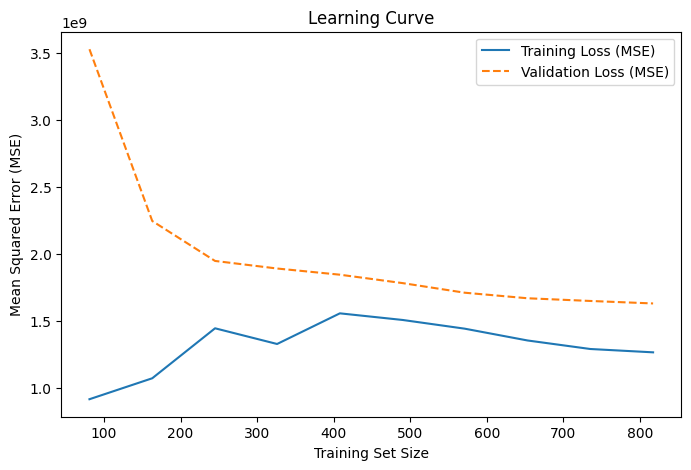

In [ ]:
from sklearn.model_selection import learning_curve

# Get learning curve
train_sizes, train_scores, val_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring="neg_mean_squared_error", train_sizes=np.linspace(0.1, 1.0, 10)
)

# Compute mean loss
train_mean = -np.mean(train_scores, axis=1)
val_mean = -np.mean(val_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label="Training Loss (MSE)")
plt.plot(train_sizes, val_mean, label="Validation Loss (MSE)", linestyle="dashed")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Learning Curve")
plt.legend()
plt.show()


# Gradient descent

#### Interpretation:
- X-axis (train_sizes) → Number of training examples used.
- Y-axis (MSE) → Error on both training and validation sets.
- Blue Line (Training Loss) → How well the model fits the training data.
- Orange Dashed Line (Validation Loss) → How well the model generalizes to unseen data.

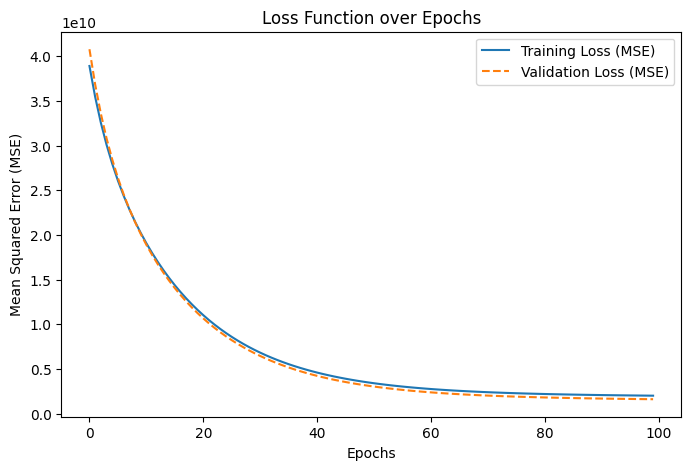

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Convert DataFrame values to numeric
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_val = X_val.astype(float)
y_val = y_val.astype(float)

# Initialize parameters
def initialize_weights(n_features):
    w = np.zeros(n_features)  # Weights
    b = 0  # Bias
    return w, b

# Compute MSE Loss
def compute_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Gradient Descent Implementation
def train_linear_regression(X_train, y_train, X_val, y_val, learning_rate=0.01, epochs=100):
    n_samples, n_features = X_train.shape
    w, b = initialize_weights(n_features)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Compute Predictions
        y_train_pred = np.dot(X_train, w) + b
        y_val_pred = np.dot(X_val, w) + b

        # Compute Loss
        train_loss = compute_mse(y_train, y_train_pred)
        val_loss = compute_mse(y_val, y_val_pred)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Compute Gradients
        dw = -(2 / n_samples) * np.dot(X_train.T, (y_train - y_train_pred))
        db = -(2 / n_samples) * np.sum(y_train - y_train_pred)

        # Update Weights
        w -= learning_rate * dw
        b -= learning_rate * db

    return train_losses, val_losses

# Train the model using gradient descent
train_losses, val_losses = train_linear_regression(X_train.values, y_train.values, X_val.values, y_val.values)

# Plot Training and Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(range(len(train_losses)), train_losses, label="Training Loss (MSE)")
plt.plot(range(len(val_losses)), val_losses, label="Validation Loss (MSE)", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Loss Function over Epochs")
plt.legend()
plt.show()


 #### Interpretation:
- X-axis (Actual Prices) → The true housing prices from the test set.
- Y-axis (Predicted Prices) → The prices predicted by the linear regression model.
- Blue Dots → Individual predictions, comparing actual vs. predicted values.
- Red Dashed Line → Ideal perfect prediction line (where actual = predicted).

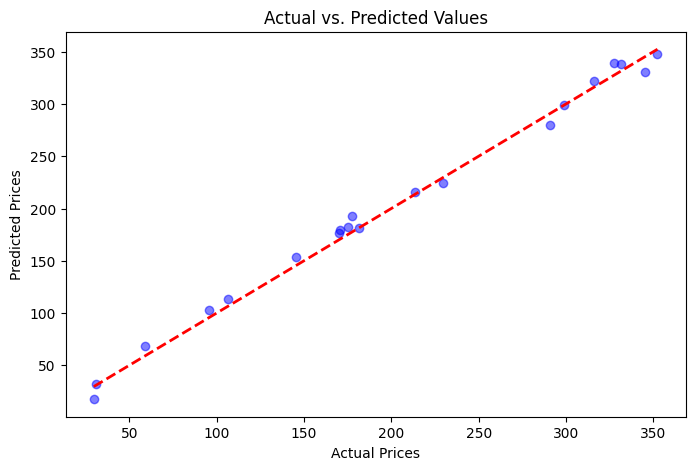

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Sample Data (Ensure X and y are properly defined)
X = np.random.rand(100, 1) * 100  # 100 random values
y = 3.5 * X.squeeze() + np.random.randn(100) * 10  # Linear relationship with noise

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Ensure `y_test` and `y_pred` are the same length
if len(y_test) != len(y_pred):
    y_test = y_test[:len(y_pred)]  # Adjust if necessary

# Plot Actual vs Predicted Values
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color="blue")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle="--", linewidth=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted Values")
plt.show()



## Residuals Histogram

#### Interpretation: 
- X-axis (Residuals) → The difference between actual and predicted values (y_test - y_pred).
- Y-axis (Frequency) → The number of occurrences of each residual value.
- Bars → Show how the residuals are distributed across different error values.
- Red Dashed Line at Zero → Ideal scenario where predicted values perfectly match actual values.

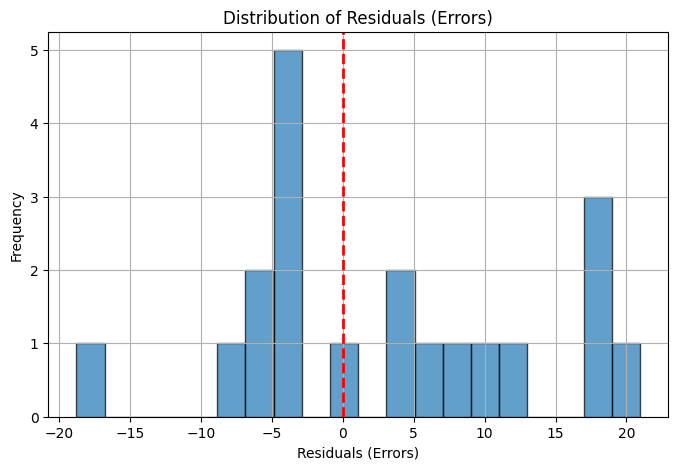

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Sample Data (Ensure X and y are properly defined)
X = np.random.rand(100, 1) * 100  # 100 random values
y = 3.5 * X.squeeze() + np.random.randn(100) * 10  # Linear relationship with noise

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Compute Residuals
residuals = y_test - y_pred  # Difference between actual and predicted values

# Plot Residuals Histogram
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle="--", linewidth=2)  # Reference line at zero
plt.xlabel("Residuals (Errors)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (Errors)")
plt.grid(True)
plt.show()


# <span style="color:yellow">⚙️ Polynomial Regression Model</span>


Polynomial Regression (Degree 2)
Root Mean Squared Error (RMSE): 3.987
R² Score: 0.998


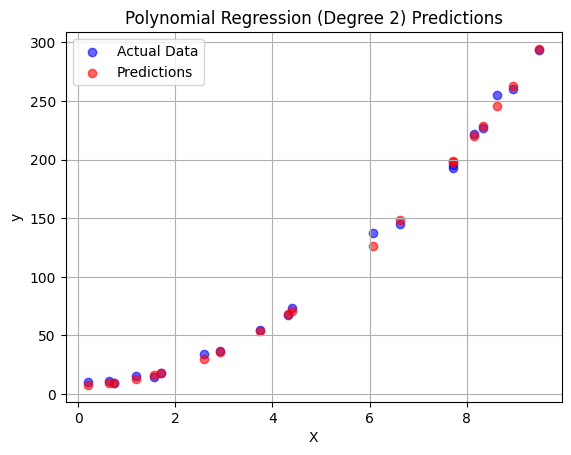

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Generate Non-Linear Data
np.random.seed(42)
X = np.random.rand(100, 1) * 10  # Feature: Random values between 0 and 10
y = 3 * (X**2) + 2 * X + 5 + np.random.randn(100, 1) * 5  # Quadratic relationship with noise

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Polynomial Regression (Degree 2)
degree = 2  # Change this for higher-degree polynomials
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate Model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Polynomial Regression (Degree {degree})")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

# Plot Actual vs Predicted
plt.scatter(X_test, y_test, color="blue", label="Actual Data", alpha=0.6)
plt.scatter(X_test, y_pred, color="red", label="Predictions", alpha=0.6)
plt.xlabel("X")
plt.ylabel("y")
plt.title(f"Polynomial Regression (Degree {degree}) Predictions")
plt.legend()
plt.grid(True)
plt.show()


# <span style="color:cyan">📈 Learning Curves Visualization</span>


# <span style="color:yellow">⚙️Lasso Regression Model</span>


# <span style="color:cyan">📈 Learning Curve Visualization</span>


# <span style="color:yellow">⚙️Ridge Regression Model</span>


# <span style="color:cyan">📈 Learning Curve Visualization</span>


# <span style="color:purple"> Predict on unseen data</span>
